In [1]:
print('test')

test


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir

In [5]:
DATASET_ID = 'bengalese_finch_sober'

In [6]:
from avgn.utils.hparams import HParams
from avgn.dataset import DataSet

In [7]:
from avgn.signalprocessing.create_spectrogram_dataset import prepare_wav, create_label_df, get_row_audio

### create dataset

In [8]:
hparams = HParams(
    num_mel_bins = 32,
    mel_lower_edge_hertz=1,
    mel_upper_edge_hertz=1995,
    butter_lowcut = 1,
    butter_highcut = 1995,
    ref_level_db = 20,
    min_level_db = -25,
    win_length_ms = 100,
    hop_length_ms = 20,
    mask_spec = True,
    mask_spec_kwargs = {"spec_thresh": 0.25, "offset": 1e-10},
    reduce_noise=True,
    noise_reduce_kwargs = {"n_std_thresh": 1.5, "prop_decrease":0.9}

)

In [9]:
# create a dataset object
dataset = DataSet(DATASET_ID, hparams = hparams)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.2s


[Parallel(n_jobs=-1)]: Done 2663 out of 2663 | elapsed:    6.0s finished


In [10]:
dataset.sample_json

OrderedDict([('species', 'Lonchura striata domestica'),
             ('common_name', 'Bengalese finch'),
             ('indvs',
              OrderedDict([('or60yw70',
                            OrderedDict([('syllables',
                                          OrderedDict([('start_times',
                                                        [0.24825,
                                                         1.29359375,
                                                         1.730375,
                                                         1.97125,
                                                         2.1615,
                                                         2.91184375,
                                                         3.11971875,
                                                         3.35384375,
                                                         3.51575,
                                                         3.674375,
                                 

In [16]:
file_lens = [dataset.data_files[i].data['length_s'] for i in list(dataset.data_files.keys())]
np.max(file_lens)

267.6239375

In [20]:
key = list(dataset.data_files.keys())[np.argmax(file_lens)]
key

'bl26lb16_200412_0908.32547'

In [21]:
### parameters
n_fft=128
hop_length_ms=1
win_length_ms=4
ref_level_db=20
pre=0.97
min_level_db=-70
silence_threshold = 0.01
min_silence_for_spec=0.1
max_vocal_for_spec=1.0,
min_syllable_length_s = 0.01
spectral_range = [500, 16000]

In [22]:
key = list(dataset.data_files.keys())[np.argmax(file_lens)]
key

'bl26lb16_200412_0908.32547'

In [23]:
wf = dataset.data_files[key].data['wav_loc']

In [24]:
import librosa
from vocalseg.utils import butter_bandpass_filter, spectrogram, int16tofloat32, plot_spec
from vocalseg.dynamic_thresholding import dynamic_threshold_segmentation

In [25]:
data, rate = librosa.core.load(wf, sr=None)
len(data)/rate

267.6239375

In [26]:
data = butter_bandpass_filter(data, 500, 15999, rate, order = 2)

In [27]:
results = dynamic_threshold_segmentation(
    data,
    rate,
    n_fft=n_fft,
    hop_length_ms=hop_length_ms,
    win_length_ms=win_length_ms,
    ref_level_db=ref_level_db,
    pre=pre,
    min_level_db=min_level_db,
    silence_threshold = silence_threshold,
    verbose=True,
    spectral_range = spectral_range,
    min_syllable_length_s = min_syllable_length_s
    
)

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
 17%|█▋        | 1/6 [00:10<00:51, 10.36s/it]

longest silence 0.03300000000000125
longest vocalization 0.6430000000000007
Current min_level_db: -70


/mnt/cube/tsainbur/Projects/github_repos/vocalization_segmentation/vocalseg/dynamic_thresholding.py:129: RuntimeWarning: invalid value encountered in sqrt
  vocal_envelope = np.max(spec, axis=0) * np.sqrt(np.mean(spec, axis=0))


longest silence 0.6350000000000051
longest vocalization 0.4519999999999982


In [28]:
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

In [31]:
figsize = (200,4)

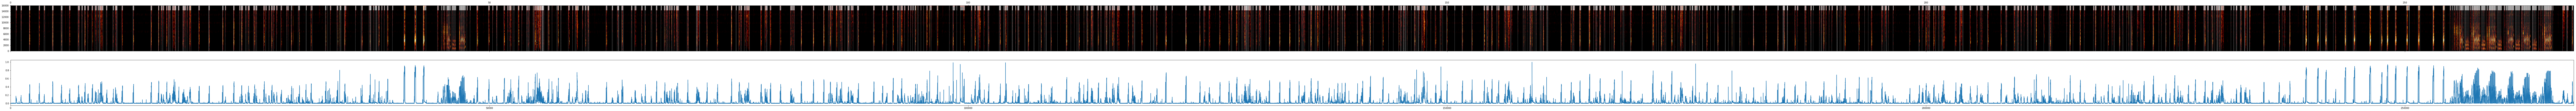

In [32]:
fig, axs = plt.subplots(nrows = 2, figsize=(figsize[0], figsize[1]*2))
plot_spec(results['spec'], fig, axs[0], rate = rate, hop_len_ms= hop_length_ms, show_cbar=False);
axs[1].plot(results['vocal_envelope'])
#axs[1].plot(results['vocal_envelope'] > silence_threshold)
axs[1].set_xlim([0, len(results['vocal_envelope'])])

ylmin, ylmax = (axs[0].get_ylim())
ysize = (ylmax - ylmin)*.1
ymin = ylmax- ysize

patches = []
for onset, offset in zip(results['onsets'], results['offsets']):
    axs[0].axvline(onset, color = '#FFFFFF', ls="dashed", lw=0.5)
    patches.append(Rectangle(xy=(onset, ymin), width = offset-onset, height = ysize))

collection = PatchCollection(patches, color='white', alpha=0.5)
axs[0].add_collection(collection);

In [27]:
from itertools import islice

def window(seq, n=2, skip = 1):
    "Returns a sliding window (of width n) over data from the iterable"
    "   s -> (s0,s1,...s[n-1]), (s1,s2,...,sn), ...                   "
    it = iter(seq)
    result = tuple(islice(it, n))
    if len(result) == n:
        yield result
    for elem in it:
        result = result[1:] + (elem,)
        yield result

In [28]:
spec = results['spec']
np.shape(spec)

(63, 32950)

In [29]:
from avgn.umap import umap_reduce

In [30]:
import seaborn as sns

In [31]:
window_length_ms = 20

In [40]:
np.shape(spec)

(63, 32950)

In [32]:
UMAP_dict = {}
for window_length_ms in tqdm([1, 20, 100]):
    window_length_frames = int(window_length_ms / hop_length_ms)
    windows = [i for i in window(spec.T, n =window_length_frames)]
    windows = np.reshape(windows, (len(windows), np.product(np.shape(windows)[1:])))
    z, _ = umap_reduce(windows, min_dist = 0.5)
    UMAP_dict[window_length_ms] = z

Exception ignored in: <bound method UMAP.__del__ of UMAP()>
Traceback (most recent call last):
  File "cuml/manifold/umap.pyx", line 313, in cuml.manifold.umap.UMAP.__del__
AttributeError: 'UMAP' object has no attribute 'umap_params'
/local/home/tsainbur/github_repos/avgn_paper/avgn/umap.py:11: UserWarning: Exception occured! file=/conda/conda-bld/libcuml_1566588242169/work/cpp/src/common/cumlHandle.cpp line=177: FAIL: call='cudaGetDevice(&cur_dev)'. Reason:no CUDA-capable device is detected

Obtained 64 stack frames
#0 in /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/cuml/common/../../../../libcuml++.so(_ZN8MLCommon9Exception16collectCallStackEv+0x3e) [0x7efdb806556e]
#1 in /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/cuml/common/../../../../libcuml++.so(_ZN8MLCommon9ExceptionC2ERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE+0x80) [0x7efdb8066080]
#2 in /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/cuml/common/../../../../lib

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/umap/utils.py", line 407:
@numba.njit(parallel=True)
def build_candidates(current_graph, n_vertices, n_neighbors, max_candidates, rng_state):
^

  current_graph, n_vertices, n_neighbors, max_candidates, rng_state
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/para

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
Exception ignored in: <bound method UMAP.__del__ of UMAP()>
Traceback (most recent call last):
  File "cuml/manifold/umap.pyx", line 313, in cuml.manifold.umap.UMAP.__del__
AttributeError: 'UMAP' object has no attribute 'umap_params'
/local/home/tsainbur/github_repos/avgn_paper/avgn/umap.py:11: UserWarning: Exception occured! file=/conda/conda-bld/libcuml_1566588242169/work/cpp/src/common/cumlHandle.cpp line=177: FAIL: call='cudaG

In [33]:
np.shape(z)

(32851, 2)

In [34]:
UMAP_dict.keys()

dict_keys([1, 20, 100])

In [81]:
from avgn.utils.general import save_fig
from avgn.utils.paths import FIGURE_DIR,ensure_dir

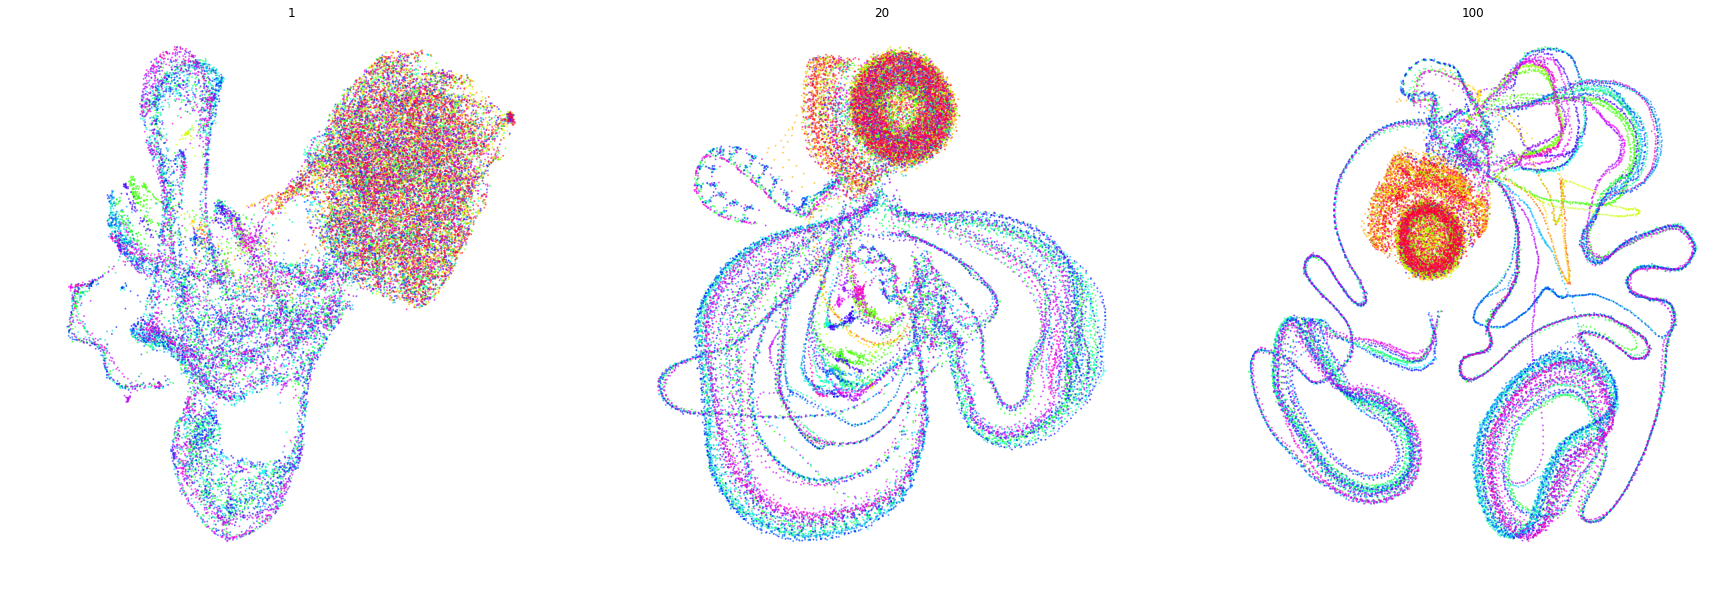

In [82]:
fig, ax = plt.subplots(ncols=3, figsize=(30,10))

for axi, window_length_ms in enumerate(UMAP_dict):
    z = UMAP_dict[window_length_ms]
    cols = sns.color_palette('hsv', len(z))
    ax[axi].scatter(z[:,0], z[:,1], alpha = 0.5, s = 1, color=cols)
    ax[axi].set_title(window_length_ms)
    ax[axi].axis('off')
ensure_dir(FIGURE_DIR/'umap_seqs' / DATASET_ID)
save_fig(FIGURE_DIR / 'umap_seqs' / DATASET_ID / 'sober_bf', save_svg=True, save_png=True)

In [117]:
syllable_df = pd.concat([pd.read_pickle(i) for i in list((DATA_DIR / 'indv_dfs' / DATASET_ID).glob('*.pickle'))])
syllable_df[:3]

start_time  end_time labels      indv  indvi                       key  \
0    9.029750  9.090969      i  or60yw70      0  or60yw70_011012_0724.503   
1    9.195656  9.267406      i  or60yw70      0  or60yw70_011012_0724.503   
2    9.321281  9.381656      a  or60yw70      0  or60yw70_011012_0724.503   

    rate                                        spectrogram  \
0  32000  [[8, 8, 8, 8, 10, 8, 56, 117, 118, 90, 71, 64,...   
1  32000  [[1, 1, 1, 1, 0, 11, 59, 70, 91, 68, 74, 48, 3...   
2  32000  [[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, ...   

   syllables_sequence_id  syllables_sequence_pos                     umap  \
0                      0                       0   [-9.551727, 2.7543738]   
1                      0                       1   [-9.808033, 2.5435884]   
2                      0                       2  [-0.17588094, 10.46355]   

   hdbscan_labels  
0               8  
1               8  
2               1

In [120]:
key_df = syllable_df[syllable_df.key == key].sort_values(by='start_time')
key_df[:3]

start_time  end_time labels      indv  indvi                         key  \
0    7.853000  7.922219      i  bl26lb16      0  bl26lb16_190412_1951.25654   
1    8.534000  8.609813      i  bl26lb16      0  bl26lb16_190412_1951.25654   
2    9.174625  9.254469      i  bl26lb16      0  bl26lb16_190412_1951.25654   

    rate                                        spectrogram  \
0  32000  [[3, 3, 3, 3, 4, 10, 11, 5, 5, 3, 4, 5, 3, 3, ...   
1  32000  [[7, 7, 7, 5, 24, 23, 14, 14, 13, 22, 42, 63, ...   
2  32000  [[8, 8, 8, 8, 18, 30, 26, 25, 35, 21, 17, 12, ...   

   syllables_sequence_id  syllables_sequence_pos                     umap  \
0                    164                       0  [-2.0859716, 5.9115634]   
1                    164                       1   [-1.7906687, 6.196261]   
2                    164                       2   [-2.3858535, 5.642858]   

   hdbscan_labels  
0              10  
1              10  
2              10

In [129]:
cols = sns.color_palette('hsv', len(z))
ax[axi].scatter(z[:,0], z[:,1], alpha = 0.5, s = 1, color=cols)
ax[axi].set_title(window_length_ms)
ax[axi].axis('off')

(-16.466537837052883,
 16.353388194108547,
 -15.968793299635673,
 13.252334979018004)

In [130]:
import numpy as np
import pylab as pl
from matplotlib.colors import hsv_to_rgb
from matplotlib import gridspec

In [131]:
def norm(x):
    return (x-np.min(x))/(np.max(x)-np.min(x))

In [132]:
rgb_imgs = []
for axi, window_length_ms in enumerate(UMAP_dict):
    z = UMAP_dict[window_length_ms]
    
    # colormap
    H = norm(z[:,0])
    V = norm(z[:,1])
    S = np.ones_like(V)
    HSV = np.dstack((H,S,V))
    RGB = hsv_to_rgb(HSV)
    RGB = [list(i) for i in np.nan_to_num(np.squeeze(RGB))]
    rgb_img = np.expand_dims(RGB,0)
    rgb_imgs.append(rgb_img)

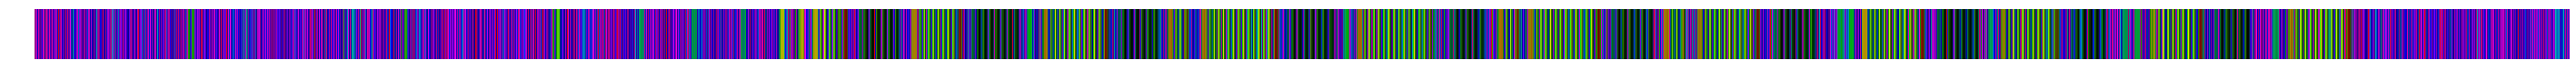

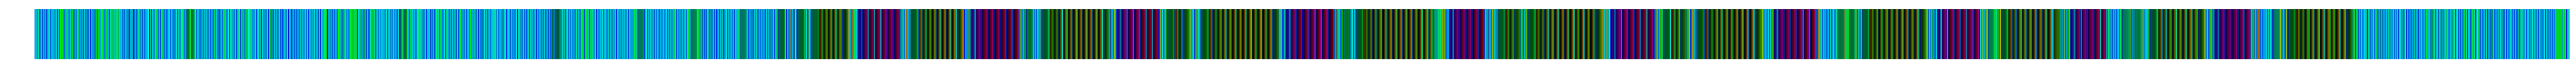

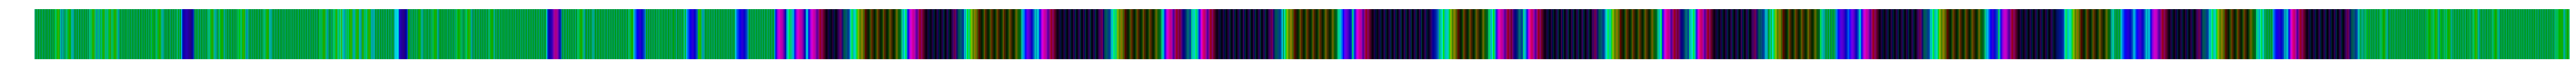

In [134]:
for window_length_ms, rgb_img in zip(UMAP_dict, rgb_imgs):
    fig, ax = plt.subplots(figsize=(50,1))
    ax.imshow(rgb_img, interpolation=None, aspect='auto')
    ax.axis('off')
    ensure_dir(FIGURE_DIR/'umap_seqs' / DATASET_ID)
    save_fig(FIGURE_DIR / 'umap_seqs' / DATASET_ID / ('sober_bf-colorspace-hsv_'+str(window_length_ms)), save_svg=True, save_png=True)

In [135]:
fig_len = 100

In [136]:
rgb_imgs = []
for axi, window_length_ms in enumerate(UMAP_dict):
    z = UMAP_dict[window_length_ms]
    
    # colormap
    R = norm(z[:,0])
    G = norm(z[:,1])
    B = np.ones_like(G)/2
    RGB = np.dstack((R,G,B))
    RGB = [list(i) for i in np.nan_to_num(np.squeeze(RGB))]
    rgb_img = np.expand_dims(RGB,0)
    rgb_imgs.append(rgb_img)

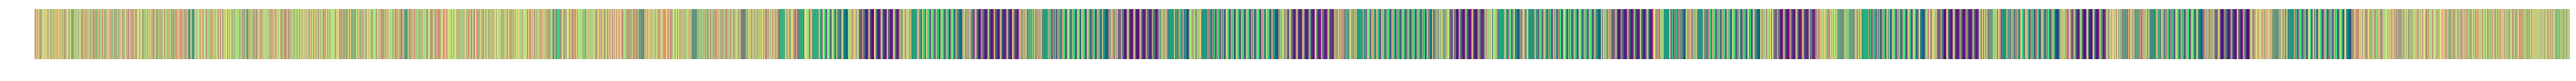

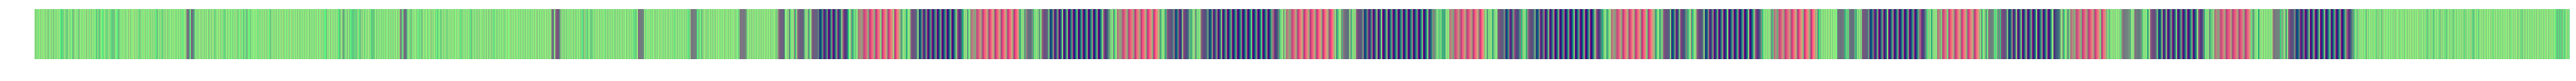

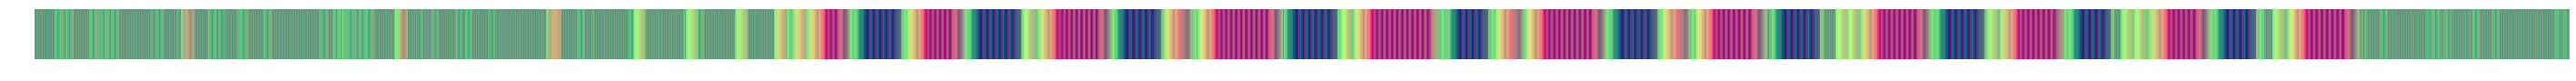

In [137]:
for window_length_ms, rgb_img in zip(UMAP_dict, rgb_imgs):
    fig, ax = plt.subplots(figsize=(50,1))
    ax.imshow(rgb_img, interpolation=None, aspect='auto')
    ax.axis('off')
    ensure_dir(FIGURE_DIR/'umap_seqs' / DATASET_ID)
    save_fig(FIGURE_DIR / 'umap_seqs' / DATASET_ID / ('sober_bf-colorspace-rgb_'+str(window_length_ms)), save_svg=True, save_png=True)

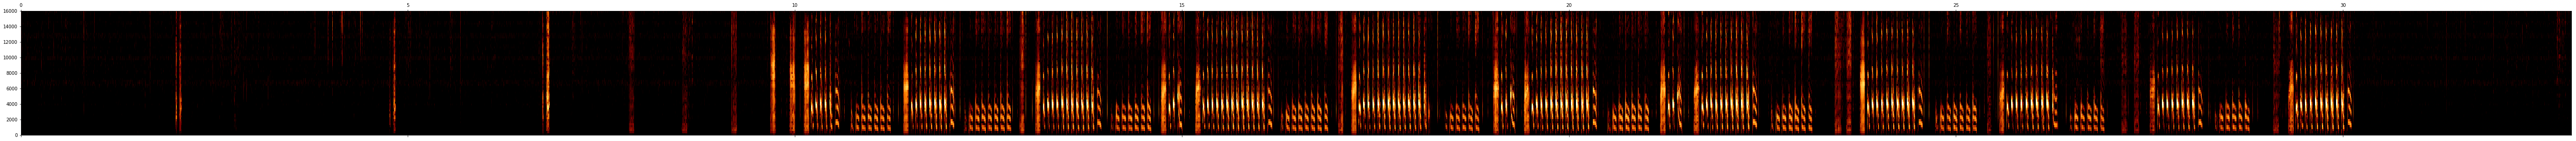

In [139]:
fig, ax = plt.subplots(figsize=(fig_len,5))
plot_spec(results['spec'], fig, ax, rate = rate, hop_len_ms= hop_length_ms, show_cbar=False);
ensure_dir(FIGURE_DIR/'umap_seqs' / DATASET_ID)
save_fig(FIGURE_DIR / 'umap_seqs' / DATASET_ID / ('sober_bf-spec_'+str(window_length_ms)), save_svg=True, save_png=True)

In [150]:
lab_pal

{'a': (1.0, 0.6485300602947661, 0.0),
 'b': (0.7029398794104678, 1.0, 0.0),
 'c': (0.03124934374934376, 1.0, 1.3125013124790507e-06),
 'd': (0.0, 1.0, 0.617278533938476),
 'e': (0.0, 0.7110320290467349, 1.0),
 'f': (0.0, 0.062501968751969, 1.0),
 'i': (0.6091898794104678, 0.0, 1.0),
 's': (1.0, 0.0, 0.742280060294766)}

In [155]:
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection

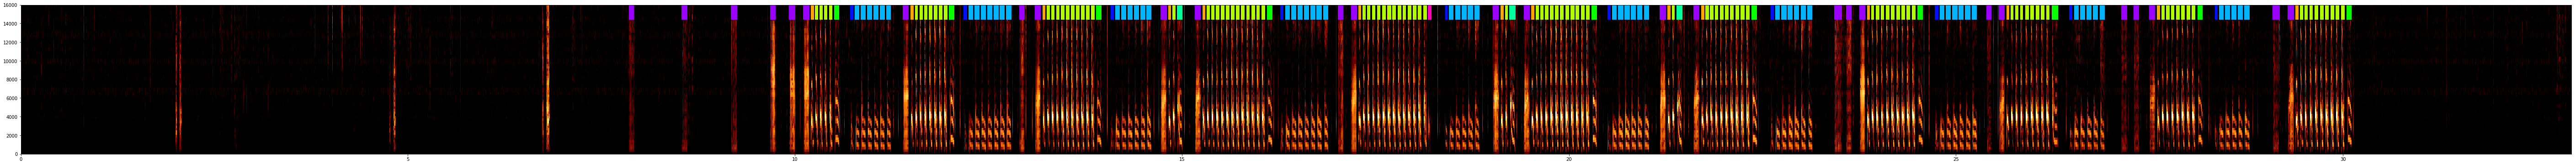

In [158]:
fig, ax = plt.subplots(figsize=(100, 6))
plot_spec(results['spec'], fig, ax, rate = rate, hop_len_ms= hop_length_ms, show_cbar=False);
ymin, ymax = ax.get_ylim()
for ix, row in tqdm(key_df.iterrows()):
    color = lab_pal[row['labels']]
    ax.add_patch(
        mpatches.Rectangle(
            [row.start_time, ymax - (ymax - ymin) / 10],
            row.end_time - row.start_time,
            (ymax - ymin) / 10,
            ec="none",
            color=color,
        )
    )
#ax.set_xlim([0.7, 9.3])
ax.xaxis.tick_bottom()

ensure_dir(FIGURE_DIR/'umap_seqs' / DATASET_ID)
save_fig(FIGURE_DIR / 'umap_seqs' / DATASET_ID / ('sober_bf-spec-lab_'+str(window_length_ms)), save_svg=True, save_png=True)

### PCA

In [140]:
from sklearn.decomposition import IncrementalPCA

In [141]:
PCA_dict = {}
for window_length_ms in tqdm([1, 20, 100]):
    window_length_frames = int(window_length_ms / hop_length_ms)
    windows = [i for i in window(spec.T, n =window_length_frames)]
    windows = np.reshape(windows, (len(windows), np.product(np.shape(windows)[1:])))
    ipca = IncrementalPCA(n_components=2, batch_size=50)
    ipca.fit(windows)
    z = ipca.transform(windows) 
    PCA_dict[window_length_ms] = z

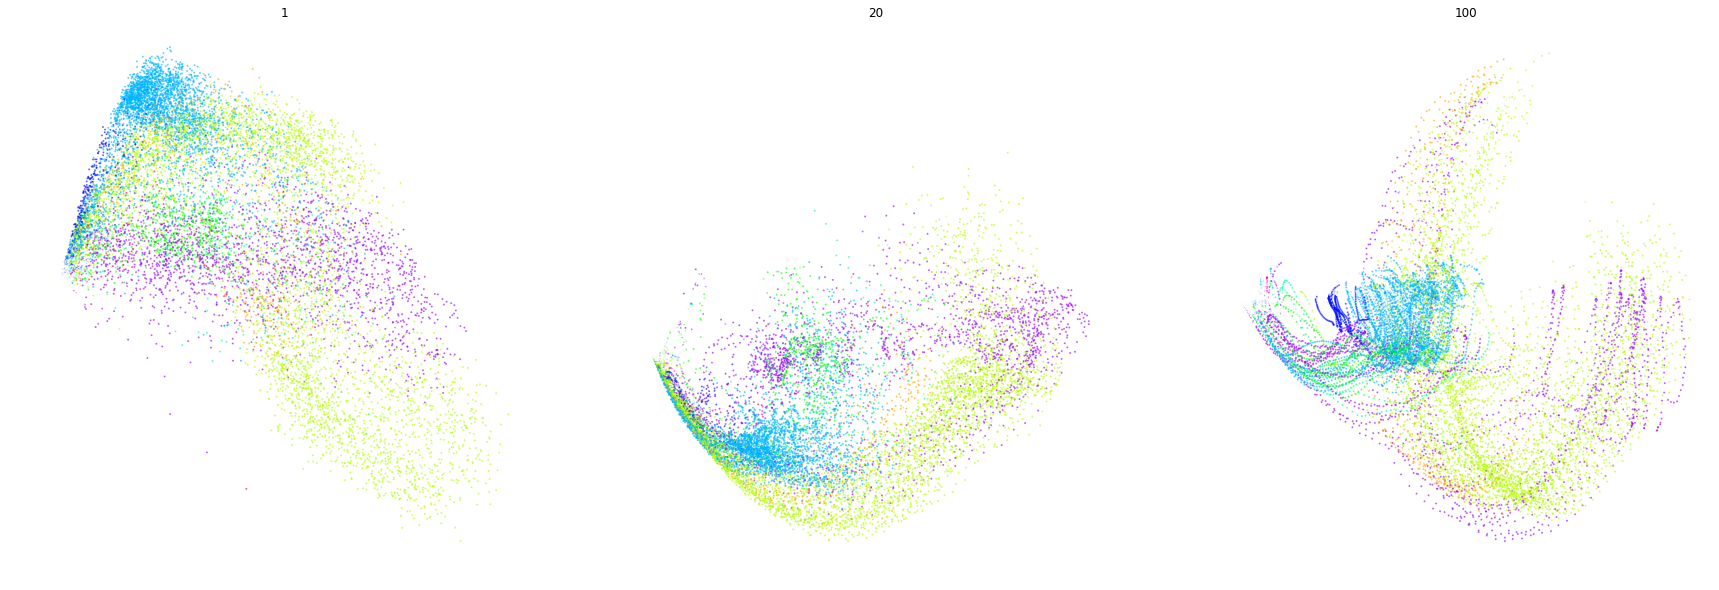

In [144]:
fig, ax = plt.subplots(ncols=3, figsize=(30,10))

for axi, window_length_ms in tqdm(enumerate(UMAP_dict)):
    
    z = PCA_dict[window_length_ms]
    labels = key_df['labels'].values
    sts = key_df.start_time.values
    ets = key_df.end_time.values
    cols = np.ones_like(sns.color_palette('hsv', len(z)))
    lab_pal = {lab:col for lab, col in zip(np.unique(labels), sns.color_palette('hsv', len(np.unique(labels))))}
    for lab, et, st in zip(labels, ets, sts):
        cols[int((st * 1000)/hop_length_ms): int((et * 1000)/hop_length_ms), :] = lab_pal[lab]
        
    ax[axi].scatter(z[:,0], z[:,1], alpha = 0.5, s = 1, color=cols)
    ax[axi].set_title(window_length_ms)
    ax[axi].axis('off')

ensure_dir(FIGURE_DIR/'umap_seqs' / DATASET_ID)
save_fig(FIGURE_DIR / 'umap_seqs' / DATASET_ID / 'sober_bf_original_label_PCA', save_png=True)

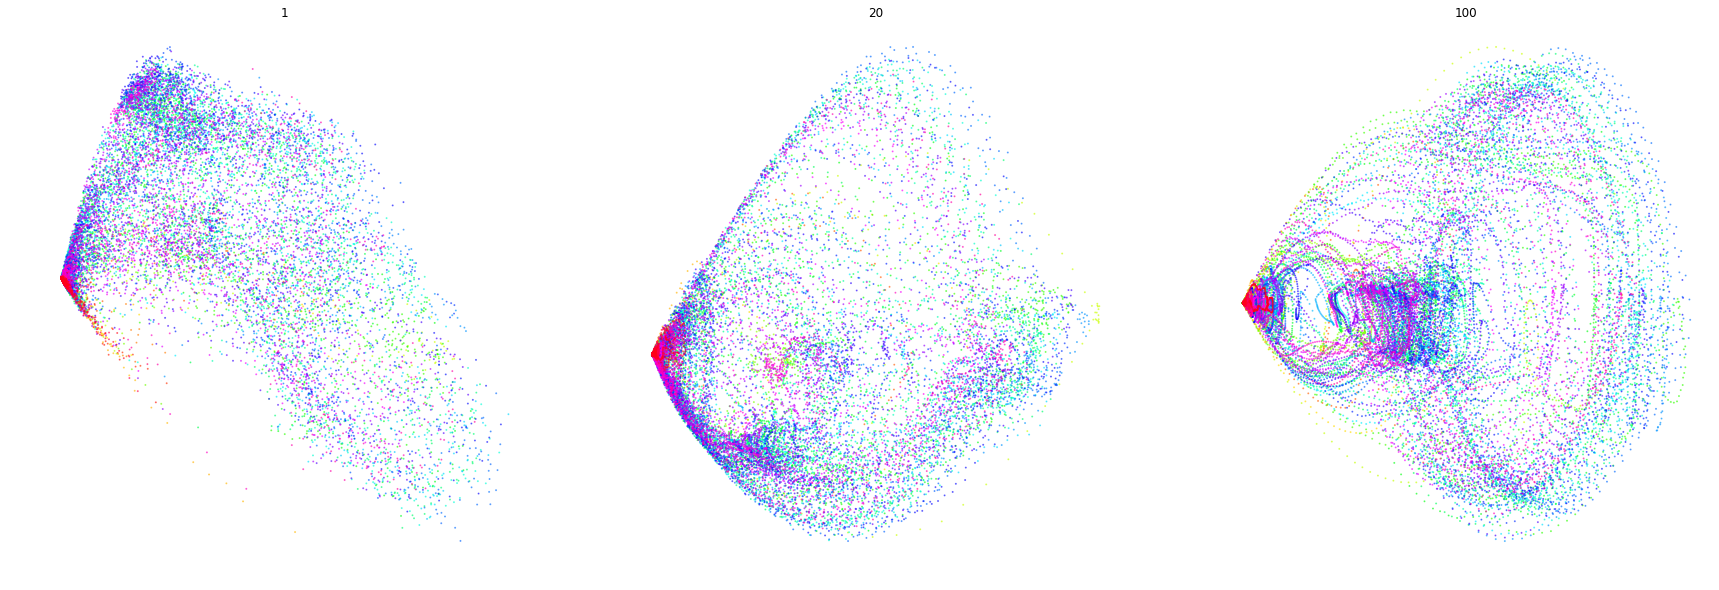

In [145]:
fig, ax = plt.subplots(ncols=3, figsize=(30,10))

for axi, window_length_ms in enumerate(UMAP_dict):
    z = PCA_dict[window_length_ms]
    cols = sns.color_palette('hsv', len(z))
    ax[axi].scatter(z[:,0], z[:,1], alpha = 0.5, s = 1, color=cols)
    ax[axi].set_title(window_length_ms)
    ax[axi].axis('off')
ensure_dir(FIGURE_DIR/'umap_seqs' / DATASET_ID)
save_fig(FIGURE_DIR / 'umap_seqs' / DATASET_ID / 'sober_bf_PCA', save_png=True)

In [78]:
ipca = IncrementalPCA(n_components=2, batch_size=50)
ipca.fit(windows)
pcs = ipca.transform(windows) 

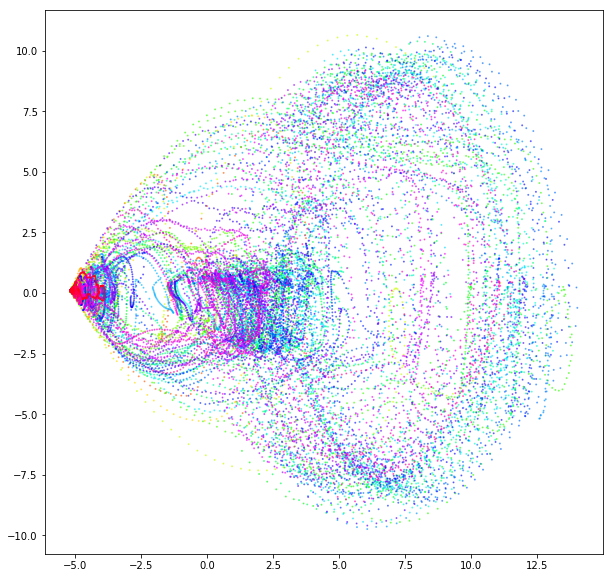

In [79]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(pcs[:,0], pcs[:,1], alpha = 0.5, s = 1, color=cols)

In [ ]:
breakme

In [ ]:
H = norm(z[:,0])
V = norm(z[:,1])
S = np.ones_like(V)
HSV = np.dstack((H,S,V))
np.shape(HSV)

In [ ]:
RGB = hsv_to_rgb(HSV)
RGB = [list(i) for i in np.nan_to_num(np.squeeze(RGB))]

In [ ]:
np.shape(cols)

In [ ]:
cols[:3]

In [ ]:
RGB[:3]

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(z[:,0], z[:,1], alpha = 0.5, s = 1, c=list(RGB))
ax.axis('off')

In [ ]:
np.shape(np.expand_dims(RGB,0))

In [ ]:
rgb_img = np.expand_dims(RGB,1)

In [ ]:
from matplotlib import gridspec

In [ ]:
figsize = (100,4)
fig = plt.figure(figsize=figsize) 
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 10], wspace=0, hspace=0) 
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
for ax in [ax1, ax0]:
    ax.axis('off')
plot_spec(results['spec'], fig, ax1, rate = rate, hop_len_ms= hop_length_ms, show_cbar=False);
ax0.imshow(np.expand_dims(RGB,0), interpolation=None, aspect='auto')
#axs[1].plot(z[:,0])
#axs[1].plot(z[:,1])
#axs[1].set_xlim([0, len(z)])